In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos

## Hough line transform

Ý tưởng của phép biến đổi là thông thường đường thẳng $y=ax+b$ được mã hóa bằng 2 giá trị $(a,b)$, thì chuyển sang không gian tọa độ cực, đường thẳng mã hóa bằng 2 giá trị $(r, \theta)$, 
* $r$ - khoảng cách từ tâm tới đường thẳng
* $\theta$ - góc xoay của đường thẳng

Ưu điểm của việc mã hóa này là giá trị $r,\theta$ luôn bị chặn khi làm việc trên ảnh $H \times W$, $0 \leq r \leq \sqrt{H^2+W^2}$ và $0 \leq \theta \leq 2\pi$ nên dễ dàng thực hiện lấy mẫu, rời rạc hóa, thống kê trên máy tính.

Chuyển đổi từ không gian tọa độ cực sang không gian đề các 2D $$y=\left( -\frac{\cos(\theta)}{\sin(\theta)}  \right)x + \left( \frac{r}{\sin(\theta)}  \right) $$ $$\cos(\theta)x + \sin(\theta)y = r$$

Để xác định các đường thẳng có trong ảnh, thực hiện bằng cách thống kê. Đường thẳng được định nghĩa ở đây là phải đi qua các pixel cạnh trong ảnh. Với mỗi pixel cạnh trong ảnh được xác định bằng thuật toán canny, tăng số lượng điểm đi qua với các đường thẳng đi qua tương ứng. Các điểm $(r, \theta)$ nào mà các có nhiều giá trị ứng với số lượng pixel cạnh mà đường thẳng đó đi qua thì sự chắc chắn đó là một đường thẳng trong ảnh càng cao.

OpenCV có hai hàm giúp thực hiện phép hough line transform 
* `HoughLines` - như đề cập trên trả về các cặp giá trị $(\theta, r_\theta)$
* `HoughLinesP` - phương pháp xác suất, trả về các đường thẳng $(x_0, y_0, x_1, y_1)$

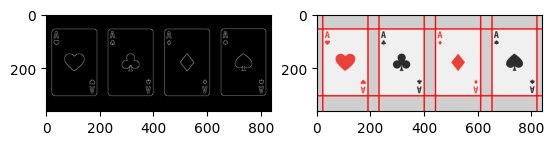

In [2]:
# Chuẩn bị ảnh
img = cv.imread('images/cards.jpg')
height, width = img.shape[:2]

if max(height, width) > 3000:
    img = cv.resize(img, (width//4, height//4))
    height, width = img.shape[:2]

dst = img.copy()

# Xác định các pixel cạnh của ảnh
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_canny = cv.Canny(img_gray, 150, 200)

# Biến đổi hough transform để xác định đường thẳng trong ảnh
# các tham sô cần truyền là: 
# - Ảnh (gray scale hoặc binary) sau khi đi qua bộ edge detector
# - Độ rộng khoảng bin của khoảng cách r khi thực hiện rời rạc hóa. Ví dụ truyền vào 1 tức là có các bin thống kê [0, 1), [1, 2), [2, 3), ...
# - Độ rộng khoảng bin của góc theta khi thực hiện rời rạc hóa. Ví dụ truyền vào pi/180 tức mỗi bin có độ rộng là 1 độ
# - Giá trị thống kê tối thiểu để được nằm trong danh sách trả về kết quả. Ví dụ truyền vào 500 tức là đường thẳng đó phải đi qua ít nhất 500 pixel cạnh trong ảnh
lines = cv.HoughLines(img_canny, 1, np.pi / 180, 200)

# Vẽ các đường thẳng
if lines is not None:
    for i in range(len(lines)):
        rho = lines[i][0][0] # khoảng cách từ tâm (0, 0) tới đường thẳng
        theta = lines[i][0][1] # góc xoay của đường thẳng đối với tâm (0, 0)

        # đường thẳng (d): ax + by = c
        a = cos(theta)
        b = sin(theta)
        c = rho
        
        # lấy điểm (x0, y0) nằm trên đường thẳng (d)
        # lấy x0 = c*cos(theta), y = c*sin(theta)
        # khi đó a*x0 + b*y0 = c * (cos(theta))^2 + c * (sin(theta))^2 = c
        x0 = c * a
        y0 = c * b

        # xác định 2 điểm đầu mút có khoảng cách rất xa nhau trên đường thẳng mà cắt ngang qua ảnh
        # thực hiện bằng cách lấy điểm (x0, y0) và đi sang hai hướng ngược nhau trên đường thẳng
        # vector chỉ phương v=(-b,a) của đường thẳng ax+by=c
        pt1 = (int(x0 + 10**4 * (-b)), int(y0 + 10**4 * a))
        pt2 = (int(x0 - 10**4 * (-b)), int(y0 - 10**4 * a))

        # vẽ đường thẳng lên ảnh, các đường thẳng sẽ được clip lại nếu quá dài để khớp với ảnh
        cv.line(dst, pt1, pt2, (0, 0, 255), 3)

plt.subplot(1, 2, 1)
plt.imshow(img_canny, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
# plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

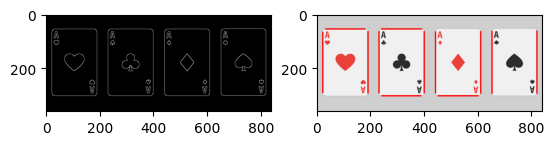

In [3]:
# Chuẩn bị ảnh
img = cv.imread('images/cards.jpg')
height, width = img.shape[:2]

if max(height, width) > 3000:
    img = cv.resize(img, (width//4, height//4))
    height, width = img.shape[:2]

dst = img.copy()

# Xác định các pixel cạnh của ảnh
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_canny = cv.Canny(img_gray, 150, 200)

# Sử dụng hough transform xác suất để xác định đoạn thẳng trong ảnh
linesP = cv.HoughLinesP(img_canny, 1, np.pi / 180, 200, 0, 100)

# Vẽ các đường thẳng
if lines is not None:
    for i in range(len(linesP)):
        l = linesP[i][0]
        # vẽ đường thẳng lên ảnh, các đường thẳng sẽ được clip lại nếu quá dài để khớp với ảnh
        cv.line(dst, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3)

plt.subplot(1, 2, 1)
plt.imshow(img_canny, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
# plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

## Hough cirle transform

Áp dụng ý tưởng tương tự hough line transform, có thể từ các pixel cạnh thống kê ra các đường tròn xuất hiện trong ảnh.

OpenCV thực hiện thông qua hàm `HoughCircles`, hàm này thực hiện luôn cả thuật toán xác định pixel cạnh canny.

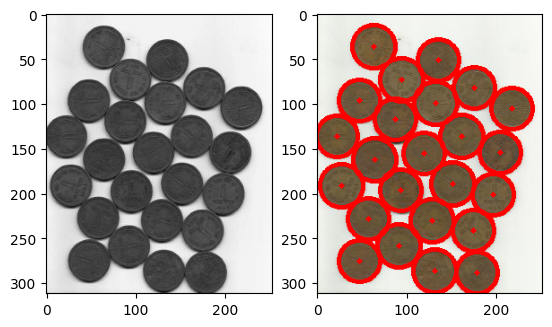

In [4]:
# Chuẩn bị ảnh
img = cv.imread('images/water_coins.jpg')
height, width = img.shape[:2]

if max(height, width) > 3000:
    img = cv.resize(img, (width//4, height//4))
    height, width = img.shape[:2]

dst = img.copy()

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Hàm Hough cirle transform
# Các tham số truyền
# - src: Ma trận ảnh gray scale
# - method: HOUGH_GRADIENT
# - dp: tỉ lệ resolution ma trận thống kê với ma trận ảnh đầu vào
# - minDist: khoảng cách tối thiểu giữa tâm các đường tròn (tránh việc nhiều đường tròn nhiễu gần nhau)
# - None
# - param1: cận trên cho thuật toán canny
# - param2: cận dưới cho thuật toán canny
# - minRadius: bán kính tối thiểu của đường tròn
# - maxRadius: bán kính tối đa của đường tròn
circles = cv.HoughCircles(img_gray, cv.HOUGH_GRADIENT, 
                          dp=1, minDist=20, 
                          circles=None, param1=150, param2=30, minRadius=1, maxRadius=50)

for i in range(len(circles[0])):
    c = circles[0][i]
    cx, cy, radius = int(c[0]), int(c[1]), int(c[2])

    # vẽ tâm đường tròn
    cv.circle(dst, (cx, cy), 1, (0, 0, 255), 3)

    # vẽ đường tròn
    cv.circle(dst, (cx, cy), radius, (0, 0, 255), 3)

plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))